In [2]:
%pip install --quiet tensorflow==2.15.0 tensorflow-io-gcs-filesystem==0.34.0
%pip install --quiet scikit-learn matplotlib pandas


Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following versions that require a different python version: 0.28.0 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement tensorflow-io-gcs-filesystem==0.34.0 (from versions: 0.29.0, 0.30.0, 0.31.0)
ERROR: No matching distribution found for tensorflow-io-gcs-filesystem==0.34.0


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os, pathlib, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)

DATA_ROOT = pathlib.Path(r"C:\Users\sarve\Downloads\Final_Project_hospital_app\xray_pneumonia\chest_xray")
TRAIN_DIR = DATA_ROOT/"train"
VAL_DIR   = DATA_ROOT/"val"
TEST_DIR  = DATA_ROOT/"test"

SAVE_DIR  = pathlib.Path(r"C:\Users\sarve\Downloads\Final_Project_hospital_app\model_store")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE   = (224, 224)      # EfficientNetB0 default input size
BATCH_SIZE = 32
SEED       = 42

print("TensorFlow:", tf.__version__)
print("Train:", TRAIN_DIR.exists(), "Val:", VAL_DIR.exists(), "Test:", TEST_DIR.exists())


TensorFlow: 2.18.0
Train: True Val: True Test: True


In [2]:
tf.random.set_seed(SEED)

def make_ds(dir_path, shuffle=True):
    return tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels="inferred",
        label_mode="binary",        # binary labels 0/1
        color_mode="rgb",           # converts grayscale to 3ch automatically
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=shuffle,
        seed=SEED
    )

train_ds = make_ds(TRAIN_DIR, shuffle=True)
val_ds   = make_ds(VAL_DIR, shuffle=False)
test_ds  = make_ds(TEST_DIR, shuffle=False)

# Cache + prefetch for speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# Compute class weights from the (unshuffled) file structure
def count_per_class(folder):
    n_pos = len(list((folder/"PNEUMONIA").glob("**/*.*")))
    n_neg = len(list((folder/"NORMAL").glob("**/*.*")))
    return n_neg, n_pos

n_neg, n_pos = count_per_class(TRAIN_DIR)
total = n_neg + n_pos
class_weight = {
    0: total / (2.0 * n_neg + 1e-8),  # NORMAL
    1: total / (2.0 * n_pos + 1e-8)   # PNEUMONIA
}
print("Train counts -> NORMAL:", n_neg, "PNEUMONIA:", n_pos)
print("Class weights:", class_weight)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Train counts -> NORMAL: 1341 PNEUMONIA: 3875
Class weights: {0: 1.944817300514747, 1: 0.6730322580636477}


In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Augmentations (light but effective for X-rays)
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")

# Base model (pretrained on ImageNet)
base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
base.trainable = False  # start by freezing

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augment(inputs)
x = preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc", curve="ROC"),
    ],
)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [4]:
import os, tensorflow as tf
from pathlib import Path

# ---------- SAFETY SWITCHES ----------
FORCE_CPU = False       # set True if your GPU keeps crashing
BATCH_SIZE = 16         # try 16; if it still crashes, set to 8

# ---------- DEVICE SETUP ----------
if FORCE_CPU:
    tf.config.set_visible_devices([], "GPU")
else:
    gpus = tf.config.list_physical_devices("GPU")
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Enabled GPU memory growth.")
            # Mixed precision for lower VRAM use
            from tensorflow.keras import mixed_precision
            mixed_precision.set_global_policy("mixed_float16")
            print("Using mixed precision (float16).")
        except Exception as e:
            print("GPU setup issue:", e, "→ falling back to CPU.")
            tf.config.set_visible_devices([], "GPU")

print("Devices:", tf.config.list_logical_devices())

# ---------- REBUILD DATASETS WITH LOWER MEMORY FOOTPRINT ----------
# Recreate datasets with new batch size and without .cache()

from tensorflow.data import AUTOTUNE

def make_ds(dir_path, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels="inferred",
        label_mode="binary",
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=shuffle,
        seed=SEED
    )
    # Basic performance tuning without caching
    return ds.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

train_ds = make_ds(TRAIN_DIR, shuffle=True)
val_ds   = make_ds(VAL_DIR,   shuffle=False)
test_ds  = make_ds(TEST_DIR,  shuffle=False)

# Quick sanity: iterate 1 batch to ensure decoding works and won’t crash
for xb, yb in train_ds.take(1):
    print("Sample batch:", xb.shape, yb.shape)

# ---------- CALLBACKS ----------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=str(SAVE_DIR/"cxr_effb0_best.keras"),
                                       monitor="val_auc", mode="max", save_best_only=True, verbose=1),
]

# ---------- (RE)BUILD / (RE)COMPILE MODEL SAFELY ----------
# If you created 'model' & 'base' earlier, reuse them; otherwise re-create (same as before)
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

try:
    base
    model
    print("Reusing existing model.")
except NameError:
    print("Building model from scratch.")
    data_augment = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ], name="augment")

    base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
    base.trainable = False

    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = data_augment(inputs)
    x = preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.35)(x)
    # If mixed precision, ensure the output layer is float32 to avoid dtype issues with loss/metrics
    dtype_out = "float32" if tf.keras.mixed_precision.global_policy().name.startswith("mixed") else None
    outputs = layers.Dense(1, activation="sigmoid", dtype=dtype_out)(x)
    model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc", curve="ROC"),
    ],
)

# ---------- STAGE 1: train head (frozen base) ----------
history1 = model.fit(
    train_ds, validation_data=val_ds, epochs=10,
    class_weight=class_weight, callbacks=callbacks, verbose=1
)

# ---------- STAGE 2: fine-tune top of the base ----------
base.trainable = True
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc", curve="ROC"),
    ],
)

history2 = model.fit(
    train_ds, validation_data=val_ds, epochs=10,
    class_weight=class_weight, callbacks=callbacks, verbose=1
)

# ---------- LOAD BEST ----------
best_path = SAVE_DIR/"cxr_effb0_best.keras"
if Path(best_path).exists():
    model = tf.keras.models.load_model(best_path)
    print("Loaded best model:", best_path)


Devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU')]
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Sample batch: (16, 224, 224, 3) (16, 1)
Reusing existing model.
Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7801 - auc: 0.8714 - loss: 0.4494 - precision: 0.9234 - recall: 0.7575
Epoch 1: val_auc improved from -inf to 0.98438, saving model to C:\Users\sarve\Downloads\Final_Project_hospital_app\model_store\cxr_effb0_best.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 160s 462ms/step - accuracy: 0.7804 - auc: 0.8716 - loss: 0.4490 - precision: 0.9235 - recall: 0.7578 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2964 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9001 - auc: 0.9690 - loss: 0.2401 - precision: 0.9675 - recall: 0.8937
Epoch 2: val_auc improved from 0.98438 to 1.00000, saving model 


Keras evaluate on TEST:
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 424ms/step - accuracy: 0.7279 - auc: 0.6038 - loss: 0.5473 - precision: 0.4089 - recall: 0.6034
Found 624 files belonging to 2 classes.

=== TEST METRICS ===
Accuracy : 0.8301
Precision: 0.8184
Recall   : 0.9359
ROC AUC  : 0.9272

Confusion matrix (labels=[NORMAL=0, PNEUMONIA=1]):
 [[153  81]
 [ 25 365]]

Classification report:
               precision    recall  f1-score   support

      NORMAL      0.860     0.654     0.743       234
   PNEUMONIA      0.818     0.936     0.873       390

    accuracy                          0.830       624
   macro avg      0.839     0.795     0.808       624
weighted avg      0.834     0.830     0.824       624



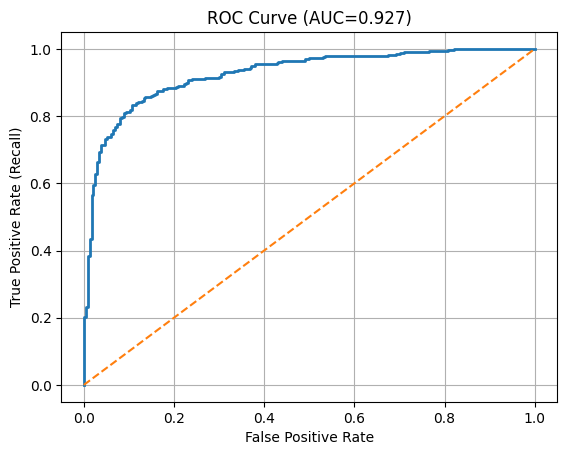

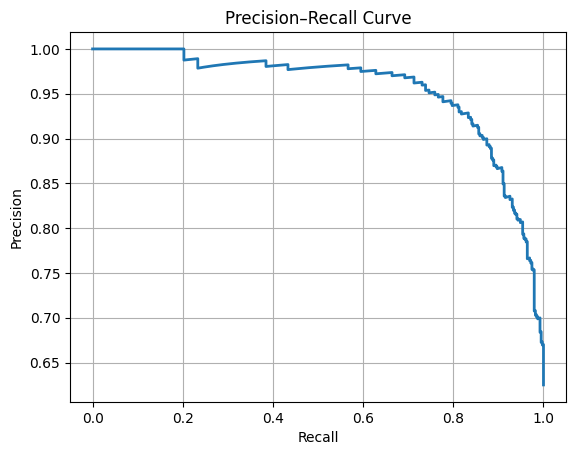


Saved:
 • Predictions → C:\Users\sarve\Downloads\Final_Project_hospital_app\model_store\cxr_test_predictions.csv
 • Metrics JSON → C:\Users\sarve\Downloads\Final_Project_hospital_app\model_store\cxr_test_metrics.json


In [5]:
import numpy as np, pandas as pd, json, matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve)

# 1) Keras quick eval
print("\nKeras evaluate on TEST:")
_ = model.evaluate(test_ds, verbose=1)

# 2) Collect predictions explicitly (for sklearn metrics & saving)
y_true, y_proba = [], []
filepaths = []

# Rebuild a filepaths dataset to keep filenames (image_dataset_from_directory can return them)
test_files = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, labels="inferred", label_mode="binary",
    image_size=IMG_SIZE, shuffle=False, batch_size=1
)
class_names = test_files.class_names  # ["NORMAL","PNEUMONIA"]

for (xb, yb) in test_files:
    proba = model.predict(xb, verbose=0).ravel()[0]
    y_proba.append(proba)
    y_true.append(int(yb.numpy().ravel()[0]))
# filepaths in the same order as the dataset iterator:
filepaths = test_files.file_paths

y_true  = np.array(y_true, dtype=int)
y_proba = np.array(y_proba)
y_pred  = (y_proba >= 0.5).astype(int)

# 3) Metrics
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
auc  = roc_auc_score(y_true, y_proba) if len(np.unique(y_true))==2 else float('nan')
cm   = confusion_matrix(y_true, y_pred, labels=[0,1])

print("\n=== TEST METRICS ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"ROC AUC  : {auc:.4f}")
print("\nConfusion matrix (labels=[NORMAL=0, PNEUMONIA=1]):\n", cm)
print("\nClassification report:\n",
      classification_report(y_true, y_pred, target_names=class_names, digits=3))

# 4) Plots (ROC + PR)
fpr, tpr, _ = roc_curve(y_true, y_proba)
pr, rc, _   = precision_recall_curve(y_true, y_proba)

plt.figure()
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC Curve (AUC={auc:.3f})"); plt.grid(True); plt.show()

plt.figure()
plt.plot(rc, pr, lw=2)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve")
plt.grid(True); plt.show()

# 5) Save predictions + metrics
pred_df = pd.DataFrame({
    "filepath": filepaths,
    "true_label": y_true,
    "pred_proba": y_proba,
    "pred_label": y_pred
})
pred_csv = SAVE_DIR/"cxr_test_predictions.csv"
pred_df.to_csv(pred_csv, index=False)

metrics = {"accuracy": float(acc), "precision": float(prec), "recall": float(rec),
           "roc_auc": float(auc), "confusion_matrix": cm.tolist(),
           "classes": class_names}
with open(SAVE_DIR/"cxr_test_metrics.json","w") as f:
    json.dump(metrics, f, indent=2)

print("\nSaved:")
print(" • Predictions →", pred_csv)
print(" • Metrics JSON →", SAVE_DIR/"cxr_test_metrics.json")


Found 624 files belonging to 2 classes.
Confusion matrix (counts) [rows=true, cols=pred]:
 [[153  81]
 [ 25 365]]


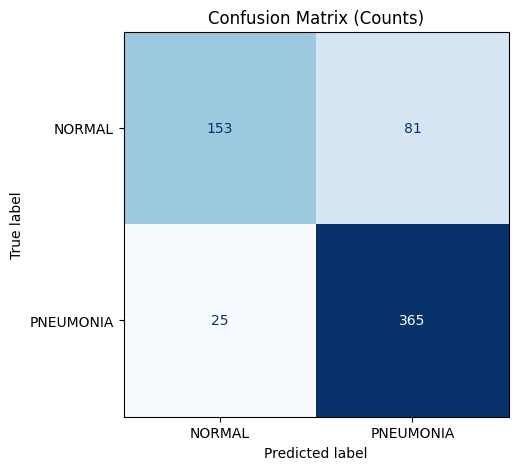

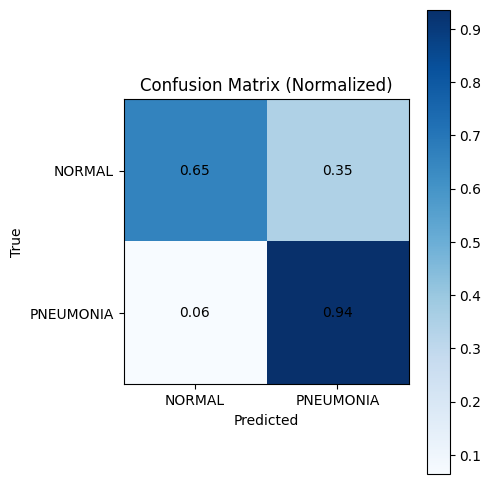

In [6]:
# Confusion matrix (counts + normalized) for TEST set
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

# Rebuild a deterministic test iterator (batch_size=1 keeps filenames/order stable)
test_files = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, labels="inferred", label_mode="binary",
    image_size=IMG_SIZE, shuffle=False, batch_size=1
)
class_names = test_files.class_names  # ["NORMAL","PNEUMONIA"]

# Collect predictions
y_true, y_proba = [], []
for xb, yb in test_files:
    y_true.append(int(yb.numpy().ravel()[0]))
    y_proba.append(float(model.predict(xb, verbose=0).ravel()[0]))

y_true  = np.array(y_true, dtype=int)
y_pred  = (np.array(y_proba) >= 0.5).astype(int)

# Confusion matrix with fixed label order: [NORMAL=0, PNEUMONIA=1]
labels = [0, 1]
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

print("Confusion matrix (counts) [rows=true, cols=pred]:\n", cm)

# Plot (counts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL","PNEUMONIA"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
plt.title("Confusion Matrix (Counts)")
plt.show()

# Plot (row-normalized)
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm_norm, cmap="Blues")
ax.set_xticks([0,1]); ax.set_xticklabels(["NORMAL","PNEUMONIA"])
ax.set_yticks([0,1]); ax.set_yticklabels(["NORMAL","PNEUMONIA"])
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix (Normalized)")
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.colorbar(im); plt.tight_layout(); plt.show()


In [ ]:
# 🩻 Chest X-ray Pneumonia Detector — Click "Browse X-ray image(s)" to upload and predict
# One-cell UI for Jupyter using ipywidgets (v7/v8 compatible)

# If widgets aren't installed, uncomment:
%pip install ipywidgets --quiet

import io, time, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import ipywidgets as W
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------- CONFIG --------
MODEL_PATH = Path(r"C:\Users\sarve\Downloads\Final_Project_hospital_app\model_store\cxr_effb0_best.keras")
IMG_SIZE   = (224, 224)   # must match training
THRESHOLD  = 0.5          # decision threshold for PNEUMONIA
USE_GPU    = False        # True if your GPU is stable; CPU is safer on some Windows setups
USE_MIXED  = False        # mixed precision (GPU only)

IDX_TO_CLASS = {0: "NORMAL", 1: "PNEUMONIA"}

# -------- DEVICE SETUP --------
if not USE_GPU:
    tf.config.set_visible_devices([], "GPU")
else:
    gpus = tf.config.list_physical_devices("GPU")
    if gpus:
        for g in gpus:
            try: tf.config.experimental.set_memory_growth(g, True)
            except Exception: pass
        if USE_MIXED:
            from tensorflow.keras import mixed_precision
            mixed_precision.set_global_policy("mixed_float16")
    else:
        print("No GPU detected → running on CPU.")

# -------- LOAD MODEL & WARM-UP --------
assert MODEL_PATH.exists(), f"Model not found: {MODEL_PATH}"
t0 = time.time()
model = tf.keras.models.load_model(MODEL_PATH)
t1 = time.time()
# warm-up to avoid first-call lag
_ = model.predict(np.zeros((1, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32), verbose=0)
t2 = time.time()

# -------- UI WIDGETS --------
uploader = W.FileUpload(
    accept=".png,.jpg,.jpeg,.bmp,.tif,.tiff",
    multiple=True,
    description="Browse X-ray image(s)"
)
predict_btn = W.Button(description="Predict", button_style="primary",
                       tooltip="Run the model on the selected image(s)")
threshold_slider = W.FloatSlider(value=THRESHOLD, min=0.1, max=0.9, step=0.05,
                                 description="Threshold", readout_format=".2f",
                                 continuous_update=False)
status = W.HTML(
    value=f"<b>Model loaded</b> in {t1 - t0:.2f}s • Warm-up {t2 - t1:.2f}s"
)
out = W.Output()

controls = W.HBox([uploader, predict_btn, threshold_slider])
display(controls, status, out)

# -------- HELPERS --------
def _predict_bytes(img_bytes: bytes, img_name: str, threshold: float):
    img = Image.open(io.BytesIO(img_bytes)).convert("RGB").resize(IMG_SIZE)
    arr = np.array(img, dtype=np.float32)
    arr = preprocess_input(arr)
    proba = float(model.predict(arr[None, ...], verbose=0).ravel()[0])
    pred  = int(proba >= threshold)
    label = IDX_TO_CLASS[pred]
    return img, proba, label

def _plot_results(results):
    # results: list of tuples (name, PIL.Image, proba, label)
    n = len(results)
    cols = 2 if n == 1 else min(3, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(5*cols, 5*rows))
    for i, (name, img, proba, label) in enumerate(results, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(img); plt.axis("off")
        plt.title(f"{label}  p={proba:.3f}\n{name}", fontsize=11)
    plt.tight_layout()
    plt.show()

def _iter_uploads(upl):
    """Yield (name, bytes) for ipywidgets FileUpload across v7 (dict) and v8 (tuple)."""
    val = upl.value
    if isinstance(val, dict):                    # ipywidgets v7
        for name, meta in val.items():
            yield name, meta.get("content", b"")
    elif isinstance(val, tuple):                 # ipywidgets v8
        for f in val:
            name = getattr(f, "name", "file")
            content = getattr(f, "content", b"")
            yield name, content

# -------- EVENTS --------
@out.capture(clear_output=True)
def on_predict_clicked(_):
    if not uploader.value:
        print("Please click 'Browse X-ray image(s)' and select at least one image.")
        return

    th = float(threshold_slider.value)
    results = []
    t_start = time.time()

    for name, content in _iter_uploads(uploader):
        if not content:
            continue
        try:
            img, proba, label = _predict_bytes(content, name, th)
            results.append((name, img, proba, label))
        except Exception as e:
            print(f"Error reading {name}: {e}")

    t_end = time.time()
    print(f"Predicted {len(results)} image(s) in {t_end - t_start:.2f}s (threshold={th:.2f})")
    for name, img, proba, label in results:
        print(f"• {name}: {label}  (p(PNEUMONIA)={proba:.3f})")

    if results:
        _plot_results(results)

predict_btn.on_click(on_predict_clicked)




Note: you may need to restart the kernel to use updated packages.


HTML(value='<b>Model loaded</b> in 0.81s • Warm-up 1.67s')

Output()